In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal as signal
import scipy.stats as stats

In [2]:
%matplotlib notebook

## Stochastic signal

Peak declustering and signal crossing detection are useful tools when analyzing (stochastic) signals. This notebook demonstrates how these tools can be used.

### Spectrum to generate signal from

Lets use a spectrum that exhibits a power-law like tail decay. This kind of spectra are common in environment description in offshore applications (https://wikiwaves.org/Ocean-Wave_Spectra).

In [3]:
ref_scale = 1.
spectrum_mode = 0.20
spectrum_shape = 4.

spectrum_scale =  spectrum_mode*((spectrum_shape + 1)/spectrum_shape)**(1./spectrum_shape)
spectrum_dist = stats.invweibull(spectrum_shape, 0., spectrum_scale)

freq_delta = 0.0005
freq = np.arange(0.005, 5., freq_delta)

spectrum_norm = spectrum_dist.pdf(freq)
spectrum = ref_scale*spectrum_norm

<IPython.core.display.Javascript object>


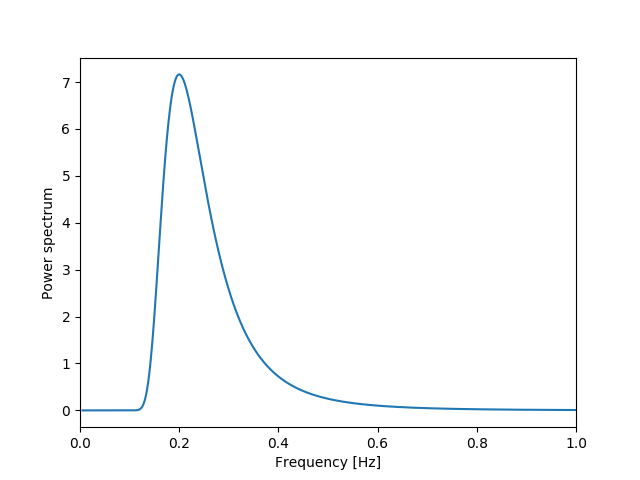

(0.0, 1.0)

In [4]:
plt.figure()
plt.plot(freq, spectrum)

plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectrum')

plt.xlim(0., 1.)

### Realize stochastic signal

Lets generate a Guassian signal based on the spectra above.

In [5]:
t = np.arange(0., 3600., step=0.1)  # 1 hour signal at 10 Hz

In [6]:
amplitudes = np.sqrt(2.)*stats.norm.rvs(0, np.sqrt(spectrum*freq_delta))
phases = stats.uniform.rvs(-np.pi, np.pi, spectrum.size)

In [7]:
theta = np.zeros(t.size)

for f, amp, phase in zip(freq, amplitudes, phases):
    f *= 2.*np.pi
    xt_arg = f*t + phase
    
    sin = np.sin(xt_arg)
    cos = np.cos(xt_arg)
    
    theta += amp*sin

<IPython.core.display.Javascript object>


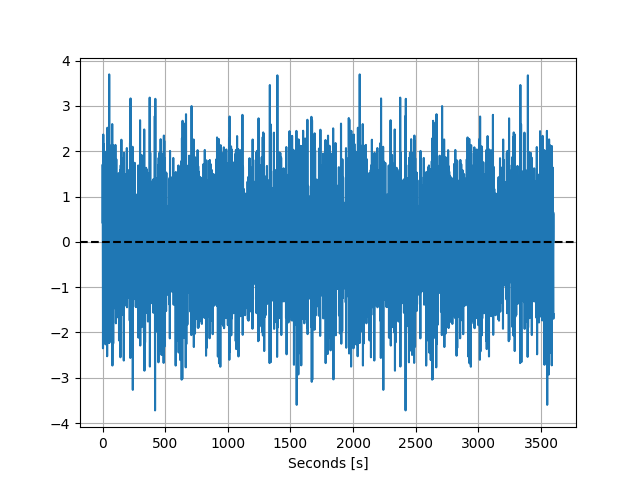

In [8]:
plt.figure()
plt.plot(t, theta)

plt.axhline(0, linestyle='--', color='k')

plt.xlabel('Seconds [s]')
plt.grid()

## Finding crossings

The proposed pull-request provides **scipy.signal.argcross**, **scipy.signal.argcrossup**, and **scipy.signal.argcrossdown** to detect "crossings" i.e. sign changes. The API is designed so that these functions behave the same way as **scipy.signal.argrelmax** etc.

In [9]:
crossings, *_ = signal.argcross(theta, threshold=0.) 

<IPython.core.display.Javascript object>


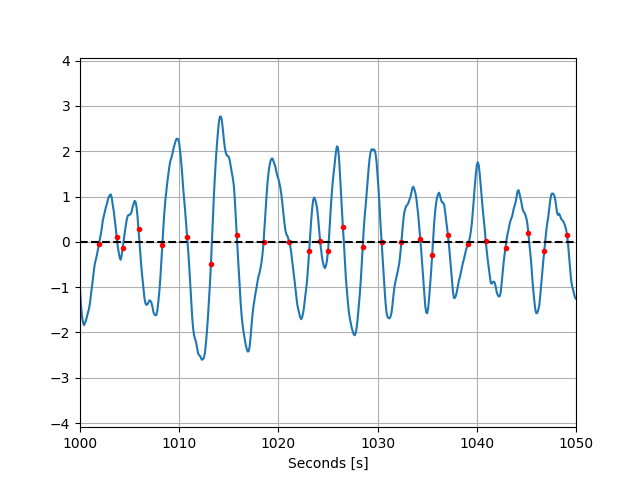

In [10]:
plt.figure()
plt.plot(t, theta)
plt.plot(t[crossings], theta[crossings], 'r.')

plt.axhline(0, linestyle='--', color='k')

plt.xlim(1000, 1050)

plt.xlabel('Seconds [s]')
plt.grid()

In [11]:
crossings_up, *_ = signal.argcrossup(theta, threshold=0.) 
crossings_down, *_ = signal.argcrossdown(theta, threshold=0.) 

<IPython.core.display.Javascript object>


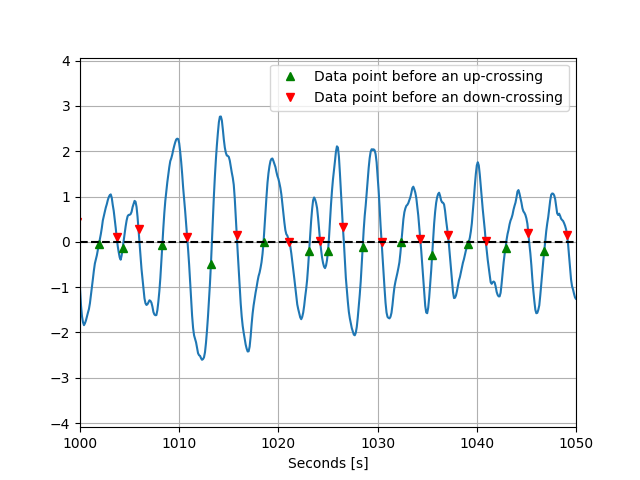

In [12]:
plt.figure()
plt.plot(t, theta)
plt.plot(t[crossings_up], theta[crossings_up], 'g^', label='Data point before an up-crossing')
plt.plot(t[crossings_down], theta[crossings_down], 'rv', label='Data point before an down-crossing')

plt.axhline(0, linestyle='--', color='k')

plt.xlim(1000, 1050)

plt.xlabel('Seconds [s]')
plt.legend()
plt.grid()

In signal analysis, there is a metric/statistics called the zero-crossing period. It describes the expected period between each signal upcrossing (i.e. each time signal goes from negative to positive.) Topic is covered in most textbooks about stocahstic signals, e.g. ref. *Naess, Arvid, and Torgeir Moan. Stochastic dynamics of marine structures. Cambridge University Press, 2012.* https://www.amazon.com/Stochastic-Dynamics-Marine-Structures-Arvid/dp/0521881552

In [13]:
freq, power_spec = scipy.signal.periodogram(theta, fs=10.)
omega = 2*np.pi*freq

m0 = np.trapz(power_spec)  # 0th spectral moment
m2 = np.trapz(omega**2 * power_spec)  # 2nd spectral moment

Estimate zero-crossing period from spectral moments

In [14]:
tz_ps = 2*np.pi*np.sqrt(m0/m2) 
tz_ps

3.5845079089119505

Estimate zero-crossing period empirically from the signal itself.

In [15]:
tz = 3600/len(crossings_up)
tz

3.6363636363636362

## Peak declustering

In analysis of signals the peaks are maybe the most interesting part. In particular, they may be used in predictive analysis, such as extreme value analysis. Therefore, being able to describe the statistical distribution of the peaks are essential.

However, analytical results are only known for some idealized cases such as Guassian signals:

* narrow-banded -> peaks will be Rayleigh distributed
* wide-banded -> peaks will be Rice distributed

In real world, these conditions seldom apply. Therefore, a more pragmatic approach is often adopted. Describe the distribution of peaks by means of Weibull distribution, or Pareto distribution (often referred to as peak-over-threshold models). However, for these models to be applicable, we should be able to assume statistical independence between the data point. (This is to avoid significant complexity in our analysis).

The statistical independence may achieved by means on 2 (common) methods, as implemented in **scipy.signal.decluster_peaks**:

    Mean-upcrossing (``mean``) declustering is as following:
     1. Identify clusters of exceedences, i.e., find all peaks between two
        upcrossings above the signal mean value.
     2. Select only the n-th largest peaks from each cluster (cf. ``order``).
     3. Exclude peaks that falls below the threshold (cf. ``x_th``).

    Runs (``runs``) declustering is as following:
     1. Identify clusters of exceedences, i.e., find all peaks between two
        upcrossings above the threshold (cf. ``x_th``).
     2. Merge clusters that are seperated with less than k runs (cf. ``runs``).
        The number of peaks below the threshold seperating a down-crossing and
        the subsequent up-crossing is called runs.
     3. Select only the n-th largest peaks from each cluster (cf. ``order``).

    The difference between the methods are subtle, and they even overplap for
    ``x_th = x.mean()`` and ``runs = 0``.

    References
    ----------
    .. [1] Coles S, (2001), An Introduction to Statistical Modelling of
        Extreme Values. Springer.



The point of both methods is to select a subset of all peaks, that can be assumed to be statistically independent. Then this subset will be amenable to simpler well-established analysis methods (and distribution functions)

#### Mean-upcrossing declustering

In [16]:
peaks_dc_1 = signal.decluster_peaks(theta, x_th=theta.mean())  # same as argerelmax, then applying a mask
peaks_dc_1 = np.concatenate(peaks_dc_1)

peaks_dc_2 = signal.decluster_peaks(theta, x_th=theta.mean(), order=2)  # same as argerelmax, then applying a mask
peaks_dc_2 = np.concatenate(peaks_dc_2)

peaks_dc_3 = signal.decluster_peaks(theta, x_th=theta.mean(), order=3)  # same as argerelmax, then applying a mask
peaks_dc_3 = np.concatenate(peaks_dc_3)

<IPython.core.display.Javascript object>


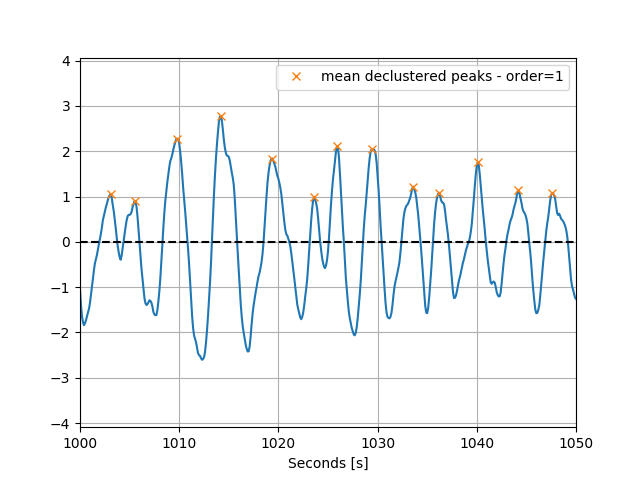

<IPython.core.display.Javascript object>


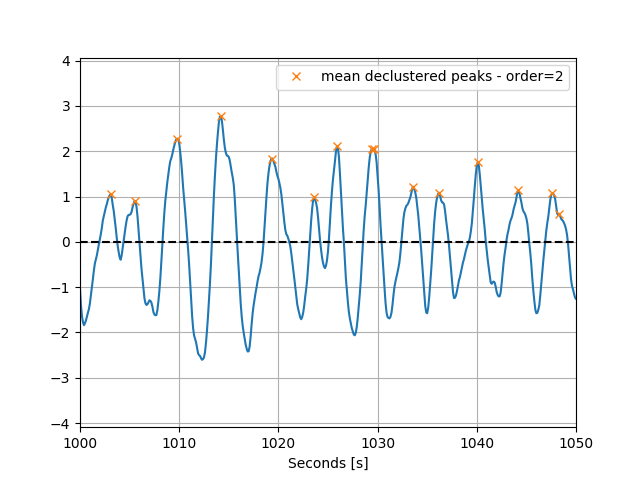

<IPython.core.display.Javascript object>


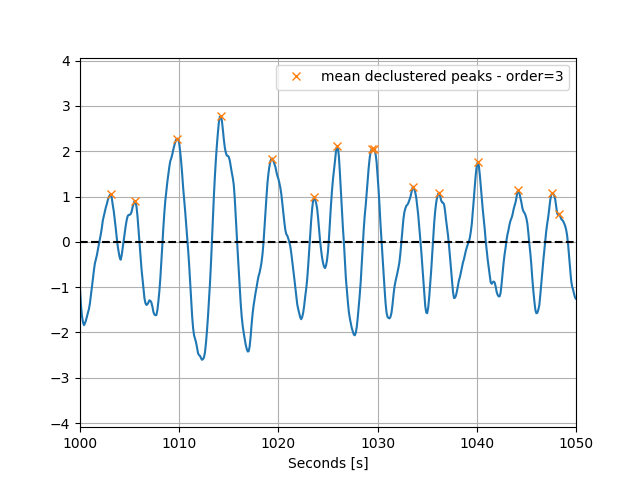

In [17]:
plt.figure()
plt.plot(t, theta)
plt.plot(t[peaks_dc_1], theta[peaks_dc_1], 'x', label='mean declustered peaks - order=1')

plt.axhline(0, linestyle='--', color='k')

plt.xlim(1000, 1050)

plt.xlabel('Seconds [s]')
plt.legend()
plt.grid()

plt.figure()
plt.plot(t, theta)
plt.plot(t[peaks_dc_2], theta[peaks_dc_2], 'x', label='mean declustered peaks - order=2')

plt.axhline(0, linestyle='--', color='k')

plt.xlim(1000, 1050)

plt.xlabel('Seconds [s]')
plt.legend()
plt.grid()

plt.figure()
plt.plot(t, theta)
plt.plot(t[peaks_dc_3], theta[peaks_dc_3], 'x', label='mean declustered peaks - order=3')

plt.axhline(0, linestyle='--', color='k')

plt.xlim(1000, 1050)

plt.xlabel('Seconds [s]')
plt.legend()
plt.grid()

Lets look at the histogram of peaks.

In [18]:
peaks, *_ = signal.argrelmax(theta)
peaks_dc_1 = signal.decluster_peaks(theta, x_th=2.)  # same as argerelmax, then applying a mask
peaks_dc_1 = np.concatenate(peaks_dc_1)

<IPython.core.display.Javascript object>


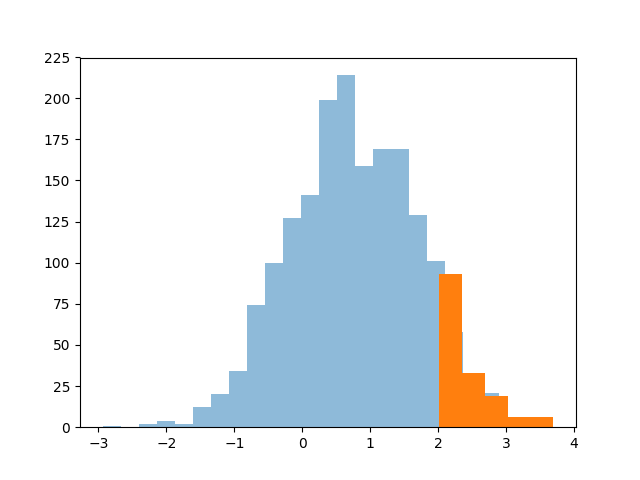

In [19]:
plt.figure()
_ = plt.hist(theta[peaks], bins=25, alpha=0.5)
_ = plt.hist(theta[peaks_dc_1], bins=5)

#### Runs declustering

In [20]:
# at least 2 peaks must occur below the threshold to count as a cluster, then pick the largest peak
peaks_dc_1 = signal.decluster_peaks(theta, x_th=1., method='runs', runs=2) 
peaks_dc_1 = np.concatenate(peaks_dc_1)

# at least 2 peaks must occur below the threshold to count as a cluster, then pick the 2 largest peak
peaks_dc_2 = signal.decluster_peaks(theta, x_th=1., order=2, method='runs', runs=2)  
peaks_dc_2 = np.concatenate(peaks_dc_2)

# at least 2 peaks must occur below the threshold to count as a cluster, then pick the 3 largest peak
peaks_dc_3 = signal.decluster_peaks(theta, x_th=1., order=3, method='runs', runs=2)
peaks_dc_3 = np.concatenate(peaks_dc_3)

<IPython.core.display.Javascript object>


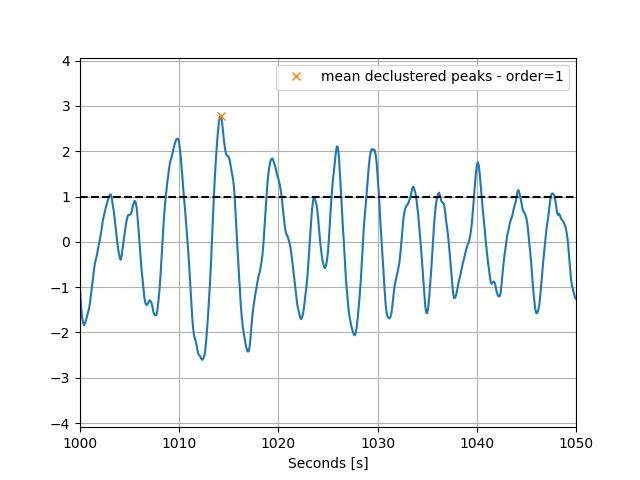

<IPython.core.display.Javascript object>


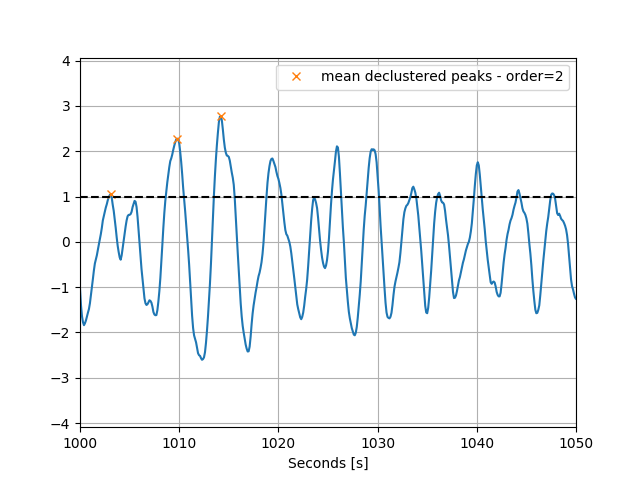

<IPython.core.display.Javascript object>


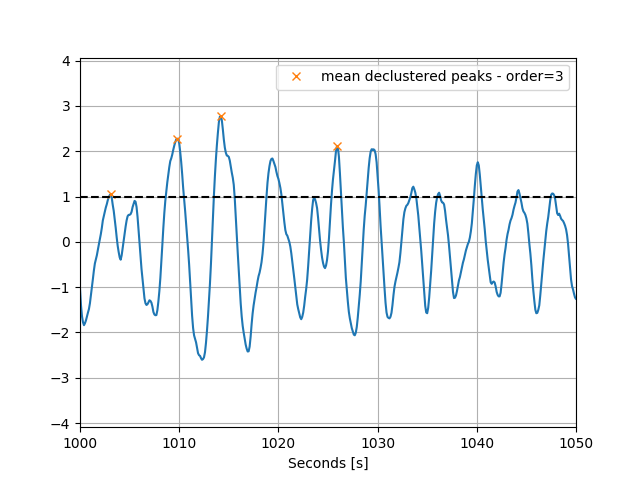

In [21]:
plt.figure()
plt.plot(t, theta)
plt.plot(t[peaks_dc_1], theta[peaks_dc_1], 'x', label='mean declustered peaks - order=1')

plt.axhline(1., linestyle='--', color='k')

plt.xlim(1000, 1050)

plt.xlabel('Seconds [s]')
plt.legend()
plt.grid()

plt.figure()
plt.plot(t, theta)
plt.plot(t[peaks_dc_2], theta[peaks_dc_2], 'x', label='mean declustered peaks - order=2')

plt.axhline(1., linestyle='--', color='k')

plt.xlim(1000, 1050)

plt.xlabel('Seconds [s]')
plt.legend()
plt.grid()

plt.figure()
plt.plot(t, theta)
plt.plot(t[peaks_dc_3], theta[peaks_dc_3], 'x', label='mean declustered peaks - order=3')

plt.axhline(1., linestyle='--', color='k')

plt.xlim(1000, 1050)

plt.xlabel('Seconds [s]')
plt.legend()
plt.grid()

In [22]:
peaks, *_ = signal.argrelmax(theta)
peaks_dc_1 = signal.decluster_peaks(theta, x_th=2., method='runs', runs=2)  # same as argerelmax, then applying a mask
peaks_dc_1 = np.concatenate(peaks_dc_1)

<IPython.core.display.Javascript object>


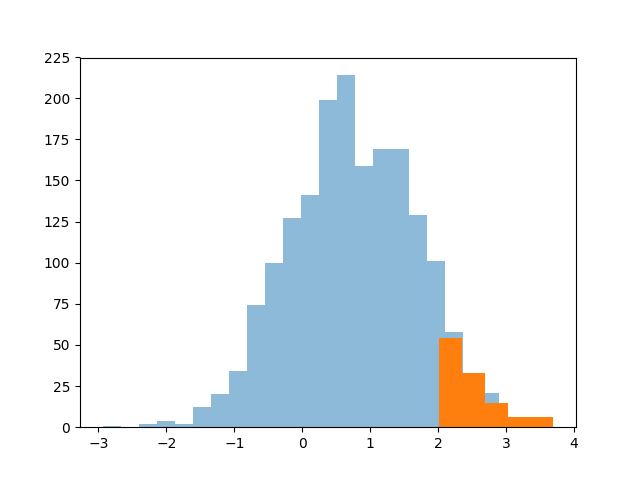

In [23]:
plt.figure()
_ = plt.hist(theta[peaks], bins=25, alpha=0.5)
_ = plt.hist(theta[peaks_dc_1], bins=5)

## References

1. Coles S, (2001), An Introduction to Statistical Modelling of
    Extreme Values. Springer.
2. Naess, Arvid, and Torgeir Moan. Stochastic dynamics of marine structures. Cambridge University Press, 2012

++

These methods are also applied in numerical software, e.g. OrcaFlex (https://www.orcina.com/SoftwareProducts/OrcaFlex/Documentation/Help/Content/html/Extremevaluestatisticstheory.htm)